In [1]:
import sys
sys.path.append('.')

In [2]:
import cv2
import numpy as np
from utils import DataGenerator, preprocess_true_boxes
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import os
import math
from models import Yolov4, yolov4_head, get_boxes, nms
from config import yolo_config
from loss import *
print(tf.__version__)

2.2.0


In [3]:
with open('./dataset/train_txt/anno2.txt') as f:
    lines = f.readlines()

NUM_CLASS = 3
FOLDER_PATH = '.'
BS = 8*2
anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]).reshape((-1, 2))
data_gen = DataGenerator(lines[:], BS, (416, 416), num_classes=NUM_CLASS, folder_path=FOLDER_PATH, anchors=anchors)
data_gen_val = DataGenerator(lines[:], BS, (416, 416), num_classes=NUM_CLASS, folder_path=FOLDER_PATH, anchors=anchors)

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = Yolov4(
                    weight_path=None,
                    class_name_path='./bccd_classes.txt'
                #    class_name_path='/content/drive/My Drive/yolo-v4-tf.keras/coco_classes.txt',
    #               weight_path='yolov4.weights',
    #                img_size=(416, 416, 3),
                  )
    model.build_model(load_pretrained=False)
    
    y_true = [
        tf.keras.layers.Input(name='input_2', shape=(52, 52, 3, (NUM_CLASS + 5))),  # label_sbbox
        tf.keras.layers.Input(name='input_3', shape=(26, 26, 3, (NUM_CLASS + 5))),  # label_mbbox
        tf.keras.layers.Input(name='input_4', shape=(13, 13, 3, (NUM_CLASS + 5))),  # label_lbbox
        tf.keras.layers.Input(name='input_5', shape=(100, 4)),             # true_bboxes
    ]
    loss_list = tf.keras.layers.Lambda(yolo_loss, name='yolo_loss',
                            arguments={'num_classes': NUM_CLASS, 'iou_loss_thresh': 0.5,
                                        'anchors': anchors.reshape((3, 3, 2))})([*model.yolo_model.output, *y_true])
    model2 = tf.keras.models.Model([model.yolo_model.input, *y_true], loss_list)

print('num class : ', model.num_classes)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [4]:
len(lines)

364

In [5]:
# model.yolo_model.load_weights('/content/drive/My Drive/yolo-v4-tf.keras/bccd.h5', by_name=True)

In [5]:


model2.compile(loss={'yolo_loss': lambda y_true, y_pred: y_pred}, optimizer=tf.keras.optimizers.Adam(lr=1e-3))
logs = np.array([])

In [6]:
model2.fit(data_gen, 
           initial_epoch=143,
           epochs=10000, 
           validation_data=data_gen_val,
            callbacks=[tf.keras.callbacks.ModelCheckpoint('bccd.h5', save_best_only=True, save_weights_only=True, monitor='val_loss'),
                      tf.keras.callbacks.ReduceLROnPlateau(factor=0.95)],
           )
# for epoch in range(50):
#     for x_batch, y_batch_tensor, y_batch_bbox in data_gen:
#         y_true = [np.zeros(BS)]
#         # print('train on batch ', y_batch_tensor[0].shape)
#         losses = model2.train_on_batch([x_batch, *y_batch_tensor, y_batch_bbox], y_true)
#         loss = losses
# #         if len(logs) > 0 and loss < np.min(logs):
# #             model.yolo_model.save('/content/drive/My Drive/yolov4-giou.h5')
#         logs = np.append(logs, loss)
#     print(f'epoch {epoch} losses ' , logs[-1])
#         # train_step(x_batch, y_batch_tensor, y_batch_bbox)

Epoch 144/10000
INFO:tensorflow:batch_all_reduce: 327 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 327 all-reduces with algorithm = nccl, num_packs = 1
23/23 [==============================] - 27s 1s/step - loss: 29596.9395 - val_loss: 62277.0234 - lr: 0.0010
Epoch 145/10000
23/23 [==============================] - 16s 705ms/step - loss: 2257.7422 - val_loss: 23850.8359 - lr: 0.0010
Epoch 146/10000
23/23 [==============================] - 16s 704ms/step - loss: 1830.4181 - val_loss: 11489.1055 - lr: 0.0010
Epoch 147/10000
23/23 [==============================] - 16s 680ms/step - loss: 1659.5220 - val_loss: 6031.6050 - lr: 0.0010
Epoch 148/10000
23/23 [==============================] - 16s 699ms/step - loss: 1426.5907 - val_loss: 4028.6619 - lr: 0.0010
Epoch 149/10000
23/23 [==============================] - 16s 691ms/step - loss: 1238.2620 - val_loss: 3414.7000 - lr: 0.0010
Epoch 150/10000
23/23 [==============================] - 13s 585ms/step - l

KeyboardInterrupt: 

In [7]:
# model.yolo_model.save('loss125.h5')
model.yolo_model.load_weights('bccd.h5', by_name=True)

In [8]:
loss2 = model2.evaluate(data_gen_val)
print(loss2) # 17.12763214111328

23/23 [==============================] - 4s 162ms/step - loss: 0.7320
0.7319941520690918


In [ ]:
# model.predict('./dataset/train_img2/test3.jpg')

dataset/train_img/BloodImage_00021.jpg
img shape:  (480, 640, 3)
nms iou: 0.5 score: 0.3
# of bboxes: 18


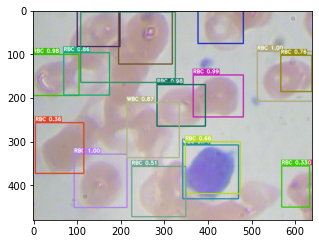

,x1,y1,x2,y2,class_name,score,w,h
0,94,329,215,451,RBC,0.997395,121,122
1,514,94,640,208,RBC,0.996994,126,114
2,367,148,482,244,RBC,0.989450,115,96
3,0,101,105,195,RBC,0.984603,105,94
4,284,170,395,265,RBC,0.978687,111,95
5,378,0,482,76,RBC,0.960967,104,76
6,215,211,335,337,WBC,0.871802,120,126
7,70,97,175,194,RBC,0.856201,105,97
8,196,0,319,123,WBC,0.764432,123,123
9,568,103,639,186,RBC,0.763743,71,83


In [9]:
i = np.random.randint(len(lines))
path = lines[i].split(' ')[0] # f'/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_img/BloodImage_00372.jpg'
print(path)
# model.predict(path)
model.predict_nonms(path, iou_threshold=0.5, score_threshold=0.3)

In [10]:
model.export_gt(annotation_path=os.path.join(FOLDER_PATH, 'dataset/train_txt/anno2.txt'), 
                gt_folder_path=os.path.join(FOLDER_PATH, 'eval/ground_truth'))

In [11]:
model.export_prediction(os.path.join(FOLDER_PATH, 'dataset/train_txt/anno2.txt'), 
                        os.path.join(FOLDER_PATH, 'eval/pred_result'),
                        os.path.join(FOLDER_PATH, 'dataset/train_img'), bs=BS)

100%|██████████| 23/23 [00:18<00:00,  1.27it/s]


['Platelets', 'RBC', 'WBC'] {'WBC': 372, 'RBC': 4155, 'Platelets': 361}
fp  47
tp  59
recall  59
prec  59
14.06% = Platelets AP 


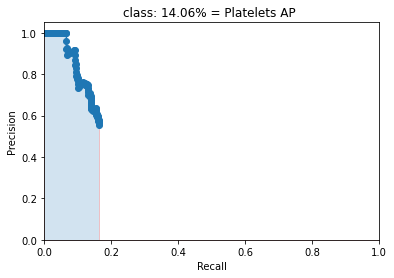

fp  799
tp  3465
recall  3465
prec  3465
81.11% = RBC AP 


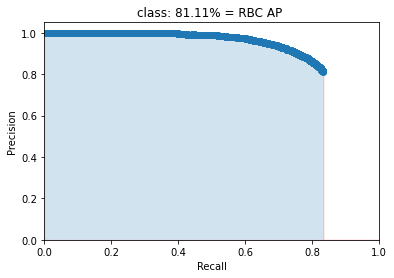

fp  683
tp  356
recall  356
prec  356
80.76% = WBC AP 


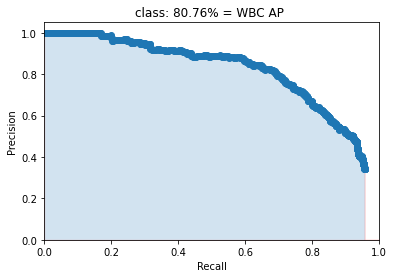

mAP = 58.64%
[('Platelets', 361), ('WBC', 372), ('RBC', 4155)]


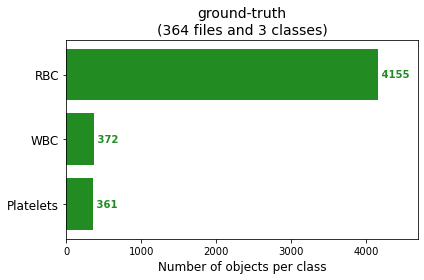

[('Platelets', 106), ('WBC', 1039), ('RBC', 4264)]


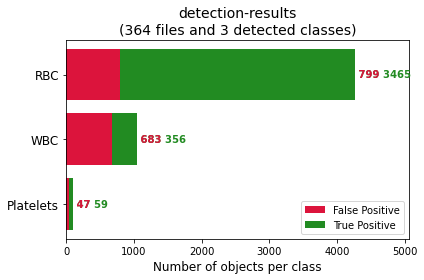

[('Platelets', 0.1406302007941702), ('WBC', 0.8075530100768717), ('RBC', 0.8111230534443625)]


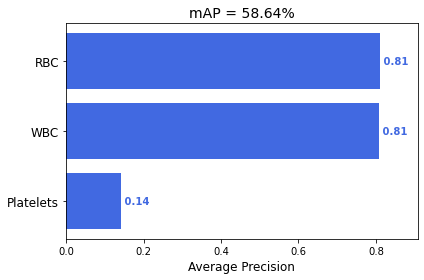

In [12]:
# mAP = 21.27%
model.eval_map(gt_folder_path = os.path.join(FOLDER_PATH, 'eval/ground_truth'), 
               pred_folder_path= os.path.join(FOLDER_PATH, 'eval/pred_result'), 
               temp_json_folder_path= os.path.join(FOLDER_PATH, 'eval/json'),
               output_files_path=os.path.join(FOLDER_PATH, 'eval/result'))